In [1]:
import pandas as pd
raw_data=pd.read_csv('Credit_card_data.csv')


In [2]:
print("shape: ",raw_data.shape)
print("\n--Data--info")
print(raw_data.info())
print("\n--summary statistics")
print(raw_data.describe())
print("\n--null values")
print(raw_data.isnull().sum())

shape:  (8950, 18)

--Data--info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  89

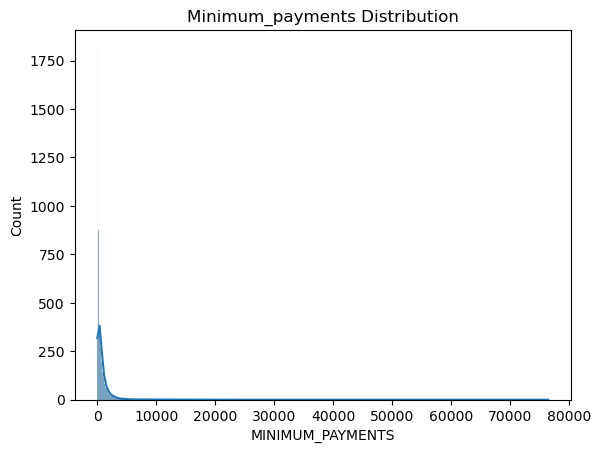

In [3]:
#we can handle the missing values 
#planning to impute rather removing the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(raw_data['MINIMUM_PAYMENTS'], kde=True)
plt.title("Minimum_payments Distribution")
plt.show()


In [4]:
#it is right_skewed, we have strong outliers
#we can impute with median as it is not normally distributed
median_minimum_payments=raw_data['MINIMUM_PAYMENTS'].median()
raw_data['MINIMUM_PAYMENTS']=raw_data['MINIMUM_PAYMENTS'].fillna(median_minimum_payments)

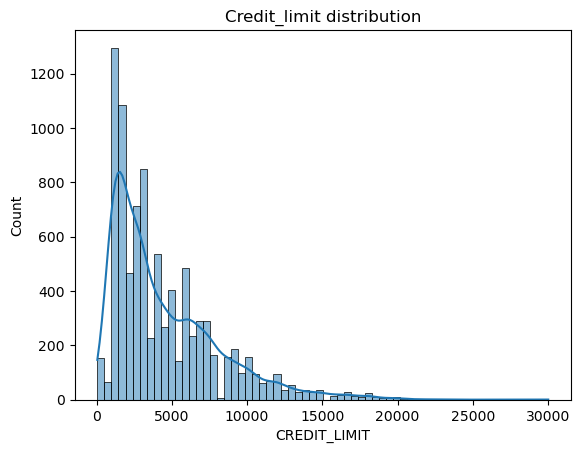

In [5]:
#Now we can check the distribution of credit_limit
#eventhough it is only 1 missing value we are not removing it 
sns.histplot(raw_data['CREDIT_LIMIT'], kde=True)
plt.title("Credit_limit distribution")
plt.show()

In [6]:
#the credit_limit is also right skewed here.
#So we can cantinue with median imputation
credit_limit_median=raw_data['CREDIT_LIMIT'].median()
raw_data['CREDIT_LIMIT']=raw_data['CREDIT_LIMIT'].fillna(credit_limit_median)

In [7]:
#Checking if we have any missing value pending
print(raw_data.isnull().sum())

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


In [8]:
#remove the unwanted_column customer_id 
raw_data = raw_data.drop(columns=['CUST_ID']) 

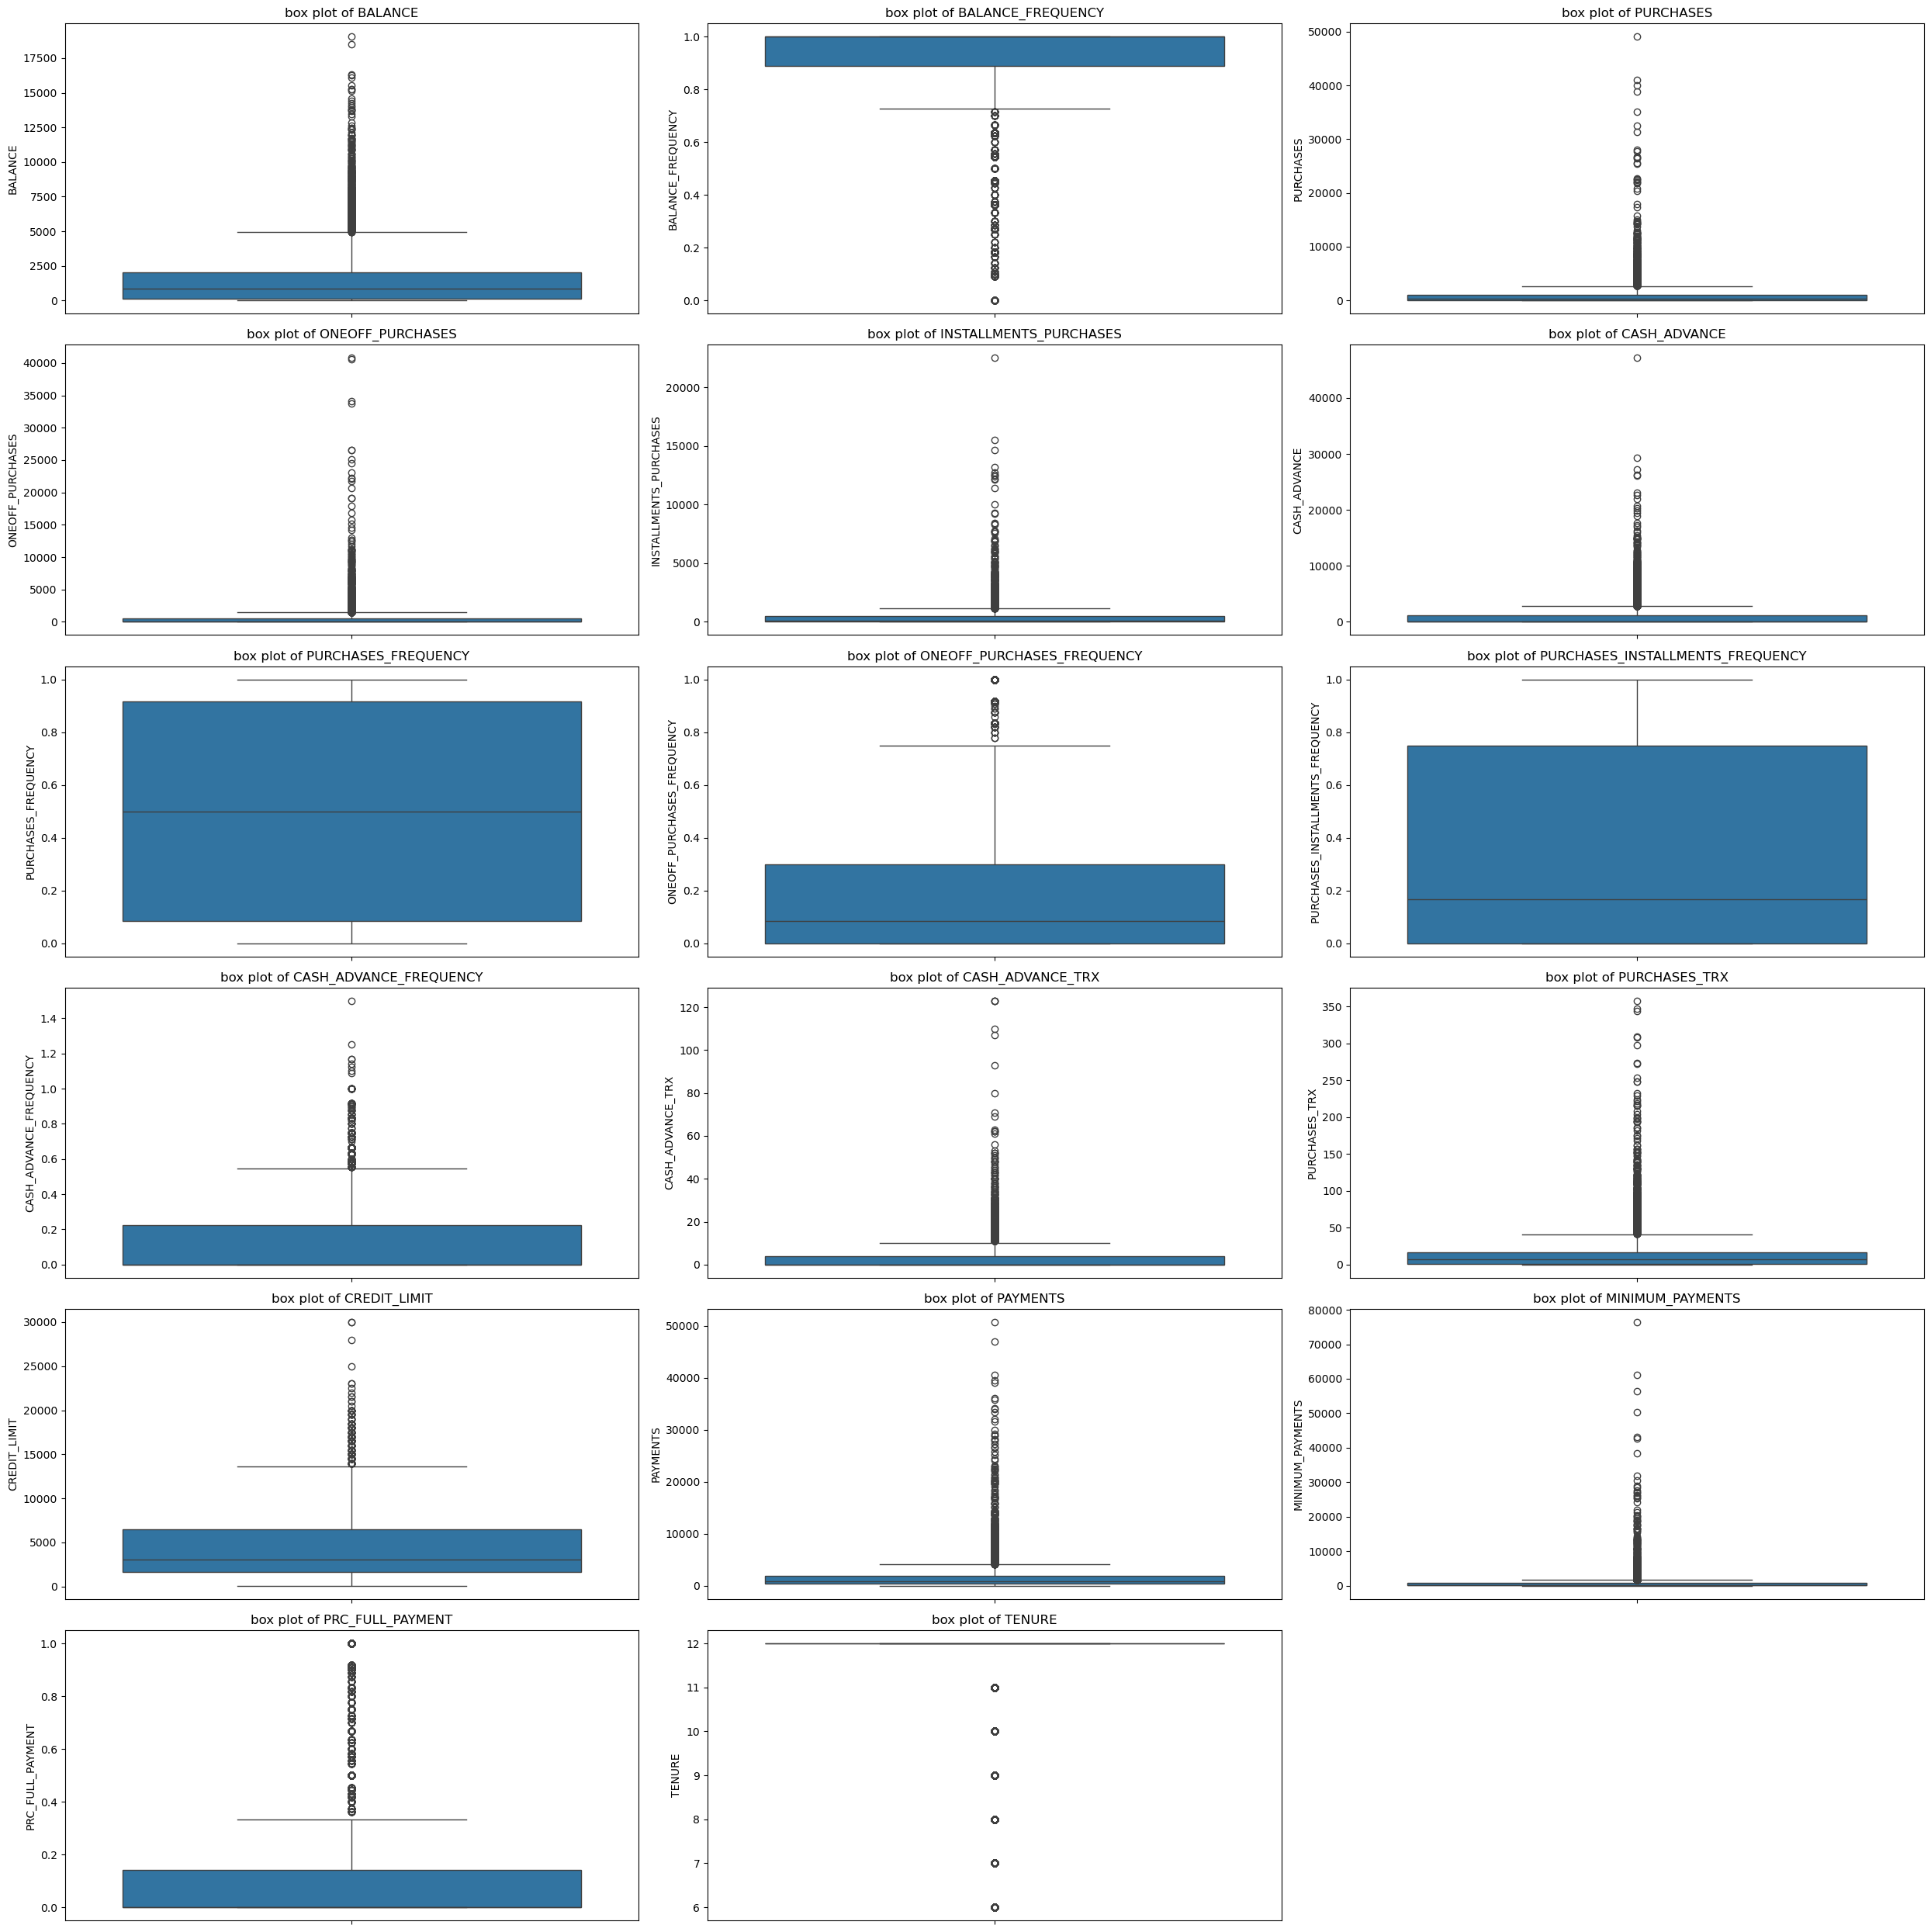

In [9]:
#removing outliers
#firstly we can see each columns as boxplot to analyze the outliers
plt.figure(figsize=(25,25))
for i,column in enumerate(raw_data.select_dtypes(include='number').columns,1):
    plt.subplot(6,3,i)
    sns.boxplot(y=raw_data[column])
    plt.title(f'box plot of {column}')
plt.tight_layout()
plt.show()

In [10]:
#remove the outliers
raw_data_copy=raw_data.copy()
all_columns=raw_data_copy.select_dtypes(include='number')

#Initialize a mask(All true is the assumption)
non_outlier_mask=pd.Series(True,index=raw_data_copy.index)

for col in all_columns:
    q1=raw_data_copy[col].quantile(0.25)
    q3=raw_data_copy[col].quantile(0.75)
    iqr=q3-q1
    lower=q1- (1.5*iqr)
    upper=q3+ (1.5*iqr)
    #getting each column inside the lower and upper range, the boolean comparison will result with the false and true values
    col_mask=(raw_data_copy[col] >= lower) & (raw_data_copy[col] <= upper)
    #the boolean results are compared ti the master mask and update accordingly for each colums
    non_outlier_mask &= col_mask

#Final outlier free dataset
outlier_iqr_data=raw_data_copy[non_outlier_mask]

print(f"Original data shape : {raw_data.shape}")
print(f"modified outlier IQR data shape : {outlier_iqr_data.shape}")


Original data shape : (8950, 17)
modified outlier IQR data shape : (2986, 17)


In [11]:
#here we have lost almost 65% of data through IQR method, this seems alarming
#lets try another method 

In [12]:
#Trying capping method or winsorization
import numpy as np
capped_data=raw_data.copy()
each_coulmns=capped_data.select_dtypes(include='number')

#initializing the master mask
capped_outlier_mask=pd.Series(True,index=capped_data.index)

for col in each_coulmns:
    q1=capped_data[col].quantile(0.25)
    q3=capped_data[col].quantile(0.75)
    iqr=q3-q1
    lower=q1-(1.5*iqr)
    upper=q3+(1.5*iqr)

    capped_data[col]=np.where(capped_data[col] < lower ,lower,
                        np.where(capped_data[col] > upper,upper, capped_data[col]))


print(f" Capped data shape : {capped_data.shape}")
    

 Capped data shape : (8950, 17)


In [13]:
#Here with winzorization we have preserved the columns
# the values below and above the quantile were replace with the lower and upper values.


In [14]:
#let we try standardizing the whole data as well
# when we standardize the rage of values will adjust around and in clustering like pricess it will help,
#our plan is to do clustering on all these data and thus compare the study how it works in each ouliers handling methedology

#Standardizing the whole raw_data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Scaled_raw_data=scaler.fit_transform(raw_data.select_dtypes(include='number'))

#let's standardize the capped_data
scaled_capped_data=scaler.fit_transform(capped_data.select_dtypes(include='number'))

#standardize the IQR data
scaled_iqr_data=scaler.fit_transform(outlier_iqr_data.select_dtypes(include='number'))

In [107]:
from sklearn.decomposition import PCA

#Initializing the PCA 
pca=PCA(n_components=2)
pca_data=pca.fit_transform(scaled_capped_data)

explained_variance=pca.explained_variance_ratio_

print(f"Explained variance of PCA1 : {explained_variance[0]:.2f}")
print(f"Explained variance of PCA2 : {explained_variance[1]:.2f}")




Explained variance of PCA1 : 0.33
Explained variance of PCA2 : 0.25


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#kmeans on  standardizzed raw data
kmeans_raw=KMeans(n_clusters=3,random_state=42)
clusters_raw=kmeans_raw.fit_predict(Scaled_raw_data)

score_raw=silhouette_score(Scaled_raw_data, clusters_raw)
print(f"Silhouette Score for Raw Data: {score_raw:.4f}")

Silhouette Score for Raw Data: 0.2067


In [17]:
#kmeans capping (winzorization)
kmeans_cap=KMeans(n_clusters=3,random_state=42)
cluster_capped=kmeans_cap.fit_predict(scaled_capped_data)

score_capped=silhouette_score(scaled_capped_data, cluster_capped)
print(f"Silhouette score for capped data : {score_capped:.4f}")

Silhouette score for capped data : 0.2376


In [18]:
#kmeans IQR method
kmeans_iqr=KMeans(n_clusters=3,random_state=42)
cluster_iqr=kmeans_iqr.fit_predict(scaled_iqr_data)

score_iqr=silhouette_score(scaled_iqr_data,cluster_iqr)
print(f"Silhouette score for iqr data : {score_iqr:.4f}")

Silhouette score for iqr data : 0.1708


In [19]:
#All three scores are not good enough , I would like to try another outlier removing method now
#let us check Z-score method, but most of the paramenters in this columns are not normally distributed
#So it seems that z-score is not an ideal choice.


In [20]:
#I feel like we have a lot of unwanted columns , this might distort the clustering eg: the customer ID 
#on the primary go through, I think we can drop customer-ID first. (code inxluded at [8]), no great difference in results
#We can check the PCA method, PCA steps are implemented after standardization.




In [21]:
#kmeans on PCA done in capped_data

kmeans_pca=KMeans(n_clusters=3,random_state=42)
cluster_pca=kmeans_pca.fit_predict(pca_data)
score_pca=silhouette_score(pca_data,cluster_pca)
print(f"silhouette score for pca data where PCA done on sclaed_capped_data : {score_pca:.4f}")

silhouette score for pca data where PCA done on sclaed_capped_data : 0.4324


In [22]:
#we have a drastic improvement in Silhouette score now.but the PCA explains only 58% of variance now
#lets try if we can improve it with  increating the PCA components.


In [23]:
pca = PCA(n_components=None)
pca.fit(scaled_capped_data)

explained_var_ratio = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var_ratio)

# Print how many components explain >= 70% variance
for i, var in enumerate(cumulative_var):
    if var >= 0.90:
        print(f"{i+1} components explain {var:.2%} of the variance")
        break


7 components explain 90.21% of the variance


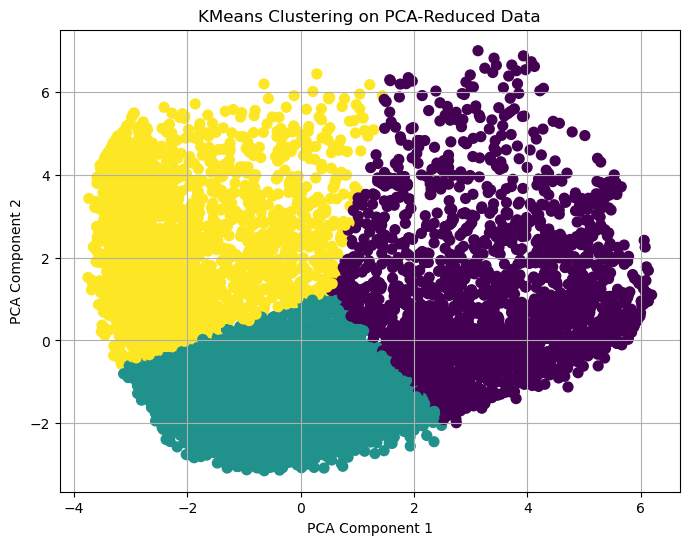

In [117]:
# Step 1: Reduce to 2 PCA components for visualization
pca_2d = PCA(n_components=2)
pca_data_2d = pca_2d.fit_transform(scaled_capped_data)

# Step 2: Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(pca_data_2d)

# Step 3: Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(pca_data_2d[:, 0], pca_data_2d[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title("KMeans Clustering on PCA-Reduced Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)



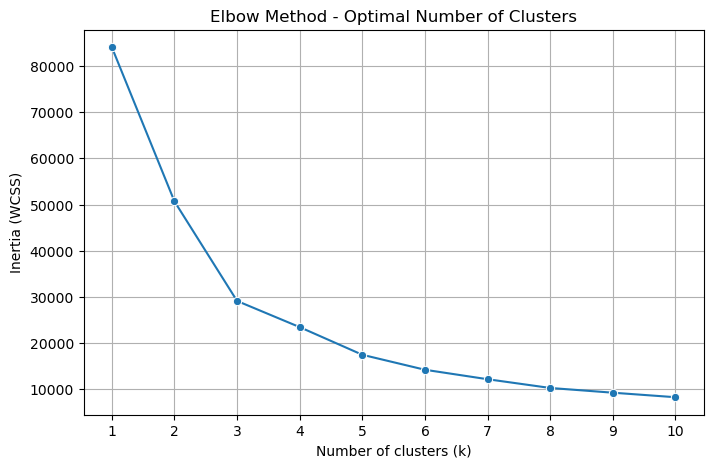

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Try K values from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)  # Use PCA-reduced data
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_range), y=inertia, marker="o")
plt.title("Elbow Method - Optimal Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [26]:
#we can see a clear elbow at k=3 so we can confirm the clear number of clusters at 3 as best one.

In [30]:
three_parameter_cluster=raw_data.copy()
print(three_parameter_cluster.info())

# we have an insight like 
#There are three features in the dataset which are very valuable for the task of credit card segmentation:
#BALANCE: The balance left in the accounts of credit card customers.
#PURCHASES: Amount of purchases made from the accounts of credit card customers.
#CREDIT_LIMIT: The limit of the credit card.
#These three features are enough to group credit card holders as they tell us about the buying history, 
#bank balance, and credit limit of the credit card holders. 
#So let’s use these features to create clusters from the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [42]:
three_parameter_cluster=three_parameter_cluster[["BALANCE","PURCHASES","CREDIT_LIMIT"]]
print(three_parameter_cluster.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BALANCE       8950 non-null   float64
 1   PURCHASES     8950 non-null   float64
 2   CREDIT_LIMIT  8950 non-null   float64
dtypes: float64(3)
memory usage: 209.9 KB
None


In [54]:
#let's scale with standardScalar
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

scaled_three_parameter_cluster=scaler.fit_transform(three_parameter_cluster.select_dtypes(include='number'))


In [88]:
#let's apply KMeans here
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_three=KMeans(n_clusters=3,random_state=42)
cluster_three=kmeans_three.fit_predict(scaled_three_parameter_cluster)

score_three=silhouette_score(scaled_three_parameter_cluster,cluster_three)
print(f"Silhoutte score for the 3 parameter dataset is : {score_three}")

Silhoutte score for the 3 parameter dataset is : 0.5391314407558482


In [123]:
# So yes this is the best Silhouette score we have got.
# let's see it visually

#let's apply PCA on the scaled_three_parameters

from sklearn.decomposition import PCA
#initializing PCA

pca=PCA(n_components=2)
pca_three=pca.fit_transform(scaled_three_parameter_cluster)

#lets try kmeans in pca_three

kmeans_pca_three=KMeans(n_clusters=3,random_state=42)
cluster_pca_three=kmeans_pca_three.fit_predict(pca_three)

score_pca_three=silhouette_score(pca_three,cluster_pca_three)
print(f"Silhouette score for pca applied three parameter dataset is  : {score_pca_three}")

Silhouette score for pca applied three parameter dataset is  : 0.5961237491667325


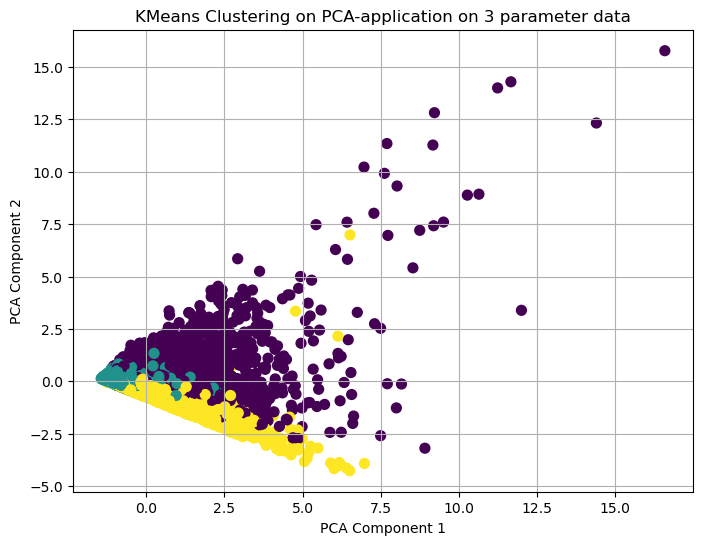

In [115]:
# now the score is even better after PCA application on the three parameter data
#lets visualize it 
plt.figure(figsize=(8,6))
plt.scatter(pca_three[:, 0], pca_three[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title("KMeans Clustering on PCA-application on 3 parameter data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)

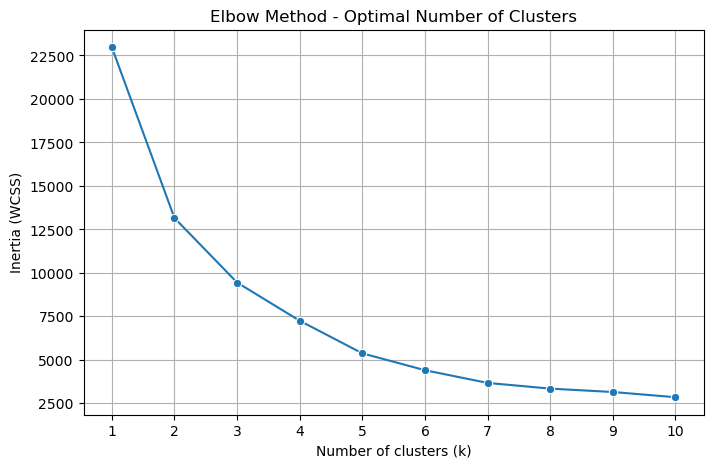

In [119]:
# Try K values from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_three)  # Use PCA-applied on 3 parameter dataset
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_range), y=inertia, marker="o")
plt.title("Elbow Method - Optimal Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
# 3 cluster are worth here ,proved with elbow method.